# SCC02713 - Introdução à Bioinformática
## Trabalho Prático: Classificação de Elementos Transponíveis
### Alunos:
Marcos Paulo Rocha Baltazar - 13782373

Rebeca Vieira Carvalho - 12543530

Yvis Freire Silva Santos - 12608793





In [ ]:
# Instalação dos prerequisitos
!pip install biopython wget
!git clone https://github.com/Bonidia/MathFeature.git MathFeature
%cd MathFeature
!pip install -r requirements.txt
!apt-get -y install python3-igraph
!pip install scikit-learn
%cd ..

fatal: destination path 'MathFeature' already exists and is not an empty directory.
/home/yvis/dev/bioinfo-final-project/MathFeature
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
/home/yvis/dev/bioinfo-final-project


In [2]:
# Importação das bibliotecas

import os
import wget
import pandas as pd
import time
from Bio import Entrez, SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from sklearn.model_selection import train_test_split

In [ ]:
# Download automático dos arquivos .gff3 dos elementos transponíveis de cada classe

classes_te = {
    'LTRS': 'TEAnnotationFinal_LTR.gff3',
    'LINES': 'TEAnnotationFinal_LINE.gff3',
    'SINES': 'TEAnnotationFinal_SINE.gff3',
    'TIRS': 'TEAnnotationFinal_TIR.gff3',
    'MITES': 'TEAnnotationFinal_MITE.gff3',
    'Helitrons': 'TEAnnotationFinal_Helitron.gff3'
}

url = 'http://apte.cp.utfpr.edu.br/te-annotation/zea_mays/'

gff_dir = 'gff3_files/'
os.makedirs(gff_dir, exist_ok=True)

for classe, filename in classes_te.items():
    if not os.path.exists(gff_dir + filename):
        wget.download(url + filename, out=gff_dir)

print("Arquivos .gff3 baixados.")

Arquivos .gff3 baixados.


In [ ]:
# Recuperando as colunas 'Chr', 'Start', 'End' das linha com strand positivo

col_names = ['Chr', 'Source', 'Class', 'Start', 'End', 'Score', 'Strand', 'Phase', 'Attributes']

all_te_locations = []

print("Iniciando processamento dos arquivos GFF3...")

for classe, filename in classes_te.items():
    file_path = os.path.join(gff_dir, filename)

    try:
        df = pd.read_csv(
            file_path,
            sep='\t',
            comment='#',
            header=None,
            names=col_names
        )

        # 1. Filtrar linhas com Strand positivo (+)
        df_filtered = df[df['Strand'].astype(str).str.strip() == '+'].copy()

        # 2. Recuperar Chr, Start e End
        df_filtered = df_filtered[['Chr', 'Start', 'End']]
        df_filtered['Start'] = pd.to_numeric(df_filtered['Start'])
        df_filtered['End'] = pd.to_numeric(df_filtered['End'])

        # 3. Adicionar a coluna da Classe
        df_filtered['Classe'] = classe

        all_te_locations.append(df_filtered)
        print(f"  - Processado {filename}: {len(df_filtered)} TEs com Strand (+)")

    except FileNotFoundError:
        print(f"ERRO: Arquivo {file_path} não encontrado. Certifique-se de fazer o upload.")
    except Exception as e:
        print(f"Erro ao processar {filename}: {e}")

# Consolida todos os TEs em um único DataFrame
if all_te_locations:
    df_locations = pd.concat(all_te_locations, ignore_index=True)
    print(f"\nProcessamento concluído. Total de TEs a extrair: {len(df_locations)}")
    print(df_locations.head())
else:
    print("\nNenhum arquivo GFF processado. Verifique os uploads e nomes dos arquivos.")

Iniciando processamento dos arquivos GFF3...
  - Processado TEAnnotationFinal_LTR.gff3: 191815 TEs com Strand (+)
  - Processado TEAnnotationFinal_LINE.gff3: 11174 TEs com Strand (+)
  - Processado TEAnnotationFinal_SINE.gff3: 3755 TEs com Strand (+)
  - Processado TEAnnotationFinal_TIR.gff3: 83849 TEs com Strand (+)
  - Processado TEAnnotationFinal_MITE.gff3: 26350 TEs com Strand (+)
  - Processado TEAnnotationFinal_Helitron.gff3: 24769 TEs com Strand (+)

Processamento concluído. Total de TEs a extrair: 341712
  Chr      Start        End Classe
0   4  122450121  122450632   LTRS
1   5    4778869    4779015   LTRS
2   2  197296548  197297070   LTRS
3   9   89034632   89035827   LTRS
4   9   39829863   39830128   LTRS


In [ ]:
# Download automático do Genoma (arquivos .fasta) via NCBI

Entrez.email = "yvis_freire@usp.br"

accession_numbers = {
    '1': 'LR618874.1',
    '2': 'LR618875.1',
    '3': 'LR618876.1',
    '4': 'LR618877.1',
    '5': 'LR618878.1',
    '6': 'LR618879.1',
    '7': 'LR618880.1',
    '8': 'LR618881.1',
    '9': 'LR618882.1',
    '10': 'LR618883.1',
    'MT': 'AY506529.1',
    'Pitd': 'X86563.2'
}

fasta_dir = 'fasta_files/'
os.makedirs(fasta_dir, exist_ok=True)

print("Baixando sequências do genoma...")

genomes = {}

for chr_name, acc_num in accession_numbers.items():
    fasta_path = os.path.join(fasta_dir, f"chr_{chr_name}.fasta")

    if not os.path.exists(fasta_path):
        try:
            handle = Entrez.efetch(db="nucleotide", id=acc_num, rettype="fasta", retmode="text")
            fasta_data = handle.read()
            handle.close()

            with open(fasta_path, "w") as f:
                f.write(fasta_data)
            print(f"  - Cromossomo {chr_name} ({acc_num}) baixado.")

        except Exception as e:
            print(f"Erro ao baixar Chr {chr_name}: {e}")
    else:
        print(f"  - Cromossomo {chr_name} já existe, pulando download.")

    try:
        record = SeqIO.read(fasta_path, "fasta")
        genomes[chr_name] = record.seq
    except Exception as e:
        print(f"Erro ao ler FASTA para Chr {chr_name}: {e}")

print("\nSequências do genoma carregadas na memória.")

Baixando sequências do genoma...
  - Cromossomo 1 já existe, pulando download.
  - Cromossomo 2 já existe, pulando download.
  - Cromossomo 3 já existe, pulando download.
  - Cromossomo 4 já existe, pulando download.
  - Cromossomo 5 já existe, pulando download.
  - Cromossomo 6 já existe, pulando download.
  - Cromossomo 7 já existe, pulando download.
  - Cromossomo 8 já existe, pulando download.
  - Cromossomo 9 já existe, pulando download.
  - Cromossomo 10 já existe, pulando download.
  - Cromossomo MT já existe, pulando download.
  - Cromossomo Pitd já existe, pulando download.

Sequências do genoma carregadas na memória.


In [38]:
# Extração dos elementos transponíveis

print("Iniciando extração das sequências de TEs...")

seq_dataset = []

for index, row in df_locations.iterrows():
    chr_name = str(row['Chr'])
    start = int(row['Start'])
    end = int(row['End'])
    classe = row['Classe']

    chromosome_seq = genomes.get(chr_name)

    if chromosome_seq:
        # Ajuste de índice: GFF (1-based) para Python (0-based)
        start_idx = start - 1
        end_idx = end

        te_seq = chromosome_seq[start_idx:end_idx]

        seq_dataset.append({
            'Cromossomo': chr_name,
            'Sequencia': str(te_seq),
            'Classe': classe
        })

df_final = pd.DataFrame(seq_dataset)


if df_final.empty:
    print("ERRO: Nenhum dado de TE foi extraído.")
else:
    print(f"\nExtração concluída. Total de sequências: {len(df_final)}")
    print("Dataset final (amostra):")
    print(df_final.head())

TAMANHO_AMOSTRA = 10000
total_sequencias = len(df_final)

# Verifica se o dataframe é maior que a amostra desejada
if total_sequencias > TAMANHO_AMOSTRA:
    print(f"\nTotal de {total_sequencias} sequências. Amostrando {TAMANHO_AMOSTRA} (mantendo proporção)...")

    # Extração de uma amostra balanceada da base de dados
    df_amostra, _ = train_test_split(
        df_final,
        train_size=TAMANHO_AMOSTRA,
        shuffle=True,
        stratify=df_final['Classe'],
        random_state=42
    )

    df_amostra = df_amostra.drop(125649)
    df_amostra = df_amostra.drop(884)
    df_amostra = df_amostra.drop(184488)

    # Salva a amostra estratificada
    df_amostra.to_csv('te_dataset_final.csv', index=False)
    print(f"Salvo {len(df_amostra)} sequências estratificadas em 'te_dataset_final.csv'")

    print("\nProporções no Dataset Original (Completo):")
    print(df_final['Classe'].value_counts(normalize=True))
    
    print("\nProporções na Amostra de 10000:")
    print(df_amostra['Classe'].value_counts(normalize=True))

else:
    # Se o total for 10000 ou menos, apenas embaralha e salva tudo
    print(f"\nTotal de {total_sequencias} sequências (menor ou igual a {TAMANHO_AMOSTRA}). Embaralhando e salvando todas.")
    
    df_final_embaralhado = df_final.sample(frac=1).reset_index(drop=True)
    df_final_embaralhado.to_csv('te_dataset_final.csv', index=False)
    print(f"Salvo {len(df_final_embaralhado)} sequências em 'te_dataset_final.csv'")

Iniciando extração das sequências de TEs...

Extração concluída. Total de sequências: 338334
Dataset final (amostra):
  Cromossomo                                          Sequencia Classe
0          4  TCACAAAGTGGATAGAATACAAGCACATCACCTCTTTGACCTCAGC...   LTRS
1          5  ACCAATTGTGTGGTGGCCCTTGCGGGGAAGTTTTGTTCCCGGCTTT...   LTRS
2          2  GCCGTTGGCGCGACGCGGGGCGCGCGCGGGCGTGCTCTGGCGAGCT...   LTRS
3          9  GTCCGGGGGACCGTTGTCCGCCCCGAGGCTATTTTAGCCAGCTCAT...   LTRS
4          9  GAAGCAGCTCGTGGAGATGCTCAAGCGGTCACCCTACTTCCTCTCC...   LTRS

Total de 338334 sequências. Amostrando 10000 (mantendo proporção)...
Salvo 9997 sequências estratificadas em 'te_dataset_final.csv'

Proporções no Dataset Original (Completo):
Classe
LTRS         0.561058
TIRS         0.245692
MITES        0.077175
Helitrons    0.072461
LINES        0.032707
SINES        0.010906
Name: proportion, dtype: float64

Proporções na Amostra de 10000:
Classe
LTRS         0.560868
TIRS         0.245774
MITES        0.077223
H

In [ ]:
for idx, row in df_amostra.iterrows():
    row['id'] = idx

df_amostra.head()
df_amostra.to_csv('te_dataset_final_index.csv')

In [ ]:
# Salvando arquivo fasta com as TEs

import subprocess

resultados = []
registros = []



with open('meu_arquivo.txt', 'w', encoding='utf-8') as f:
    for idx, row in df_amostra.iterrows():
        reg = SeqRecord(Seq(row["Sequencia"]), id=f"seq_{idx}", description=row["Classe"])
        f.write(f"{idx}\n")
        registros.append(reg)

SeqIO.write(registros, "unprocessed_todas.fasta", "fasta")


9997

In [40]:
# Preprocessamento do arquivo com as sequencias com ferramenta do MathFeature
cmd = [
    "python3", "MathFeature/preprocessing/preprocessing.py",
    "-i", "unprocessed_todas.fasta",
    "-o", "todas.fasta"
]

try:
    subprocess.run(cmd, check=True, capture_output=True, text=True)
except subprocess.CalledProcessError as e:
    print("=== ERRO NO SCRIPT MATHFEATURE ===")
    print(e.stdout)
    print(e.stderr)

In [ ]:
# Rodar MathFeature no modo Kmers
cmd = [
    "python3", "MathFeature/methods/ExtractionTechniques.py",
    "-i", "todas.fasta",
    "-o", "features_kmers.csv",
    "-l", "DNA",
    "-t", "kmer",
    "-seq", "1"
]

try:
    subprocess.run(cmd, input='3\n',check=True, capture_output=True, text=True)
except subprocess.CalledProcessError as e:
    print("=== ERRO NO SCRIPT MATHFEATURE ===")
    print(e.stdout)
    print(e.stderr)

# Ler features geradas
df_feat = pd.read_csv("features_kmers.csv")

df_feat.head()

In [ ]:
# Rodar MathFeature no modo de mapeamento numérico e transformada de Fourier
cmd = [
    "python3", "MathFeature/methods/ExtractionTechniques.py",
    "-i", "todas.fasta",
    "-o", "features_fourier.csv",
    "-l", "DNA",
    "-t", "kmer",
    "-seq", "1"
]

try:
    subprocess.run(cmd, input='3\n',check=True, capture_output=True, text=True)
except subprocess.CalledProcessError as e:
    print("=== ERRO NO SCRIPT MATHFEATURE ===")
    print(e.stdout)
    print(e.stderr)

# Ler features geradas
df_feat = pd.read_csv("features_fourier.csv")

df_feat.head()

### Leitura dos dataframes e processamento dos DataFrames

In [4]:

df_te = pd.read_csv('te_dataset_final_index.csv')
df_kmers = pd.read_csv('features_kmers.csv')
df_fourier = pd.read_csv('features_fourier.csv')

# Renomear a coluna nameseq para id do df_fourier e df_kmers
df_fourier = df_fourier.rename(columns={"nameseq": "id"})
df_kmers = df_kmers.rename(columns={"nameseq": "id"})

# Remover o prefixo "seq_" e deixar apenas o número
df_fourier["id"] = df_fourier["id"].str.replace("seq_", "", regex=False)
df_kmers["id"] = df_kmers["id"].str.replace("seq_", "", regex=False)

# Converte o tipo de obj para int
df_fourier["id"] = df_fourier["id"].astype(int)
df_kmers["id"] = df_kmers["id"].astype(int)
# Concatenando df_te com df_kmers pelo id

df_concat_kmers = pd.merge(df_te, df_kmers, on="id", how="inner") 
# Conferir resultado
df_concat_kmers.head()
# Concatenar df_te e df_fourier pelo id
df_concat_fourier = pd.merge(df_te, df_fourier, on="id", how="inner") 
# Conferir resultado
df_concat_fourier.head()
#Criando csv dos dataframes concatenados

df_concat_kmers.to_csv("df_concat_kmers.csv", index=False)
df_concat_fourier.to_csv("df_concat_fourier.csv", index=False)

### Kmers - Modelos

#### SVC - RBF

=== Métricas Hold-out (70/30) — SVC RBF ===
Accuracy           : 0.38597662771285474
Balanced Accuracy  : 0.2551695215890768
F1-macro           : 0.22635989529070485

Relatório por classe:

              precision    recall  f1-score   support

   Helitrons      0.110     0.336     0.166       217
       LINES      0.031     0.051     0.039        98
        LTRS      0.742     0.389     0.511      1680
       MITES      0.164     0.260     0.201       231
       SINES      0.000     0.000     0.000        33
        TIRS      0.399     0.495     0.442       736

    accuracy                          0.386      2995
   macro avg      0.241     0.255     0.226      2995
weighted avg      0.536     0.386     0.424      2995

AP (área sob a PR):
  Helitrons: 0.107
  LINES: 0.032
  LTRS: 0.749
  MITES: 0.131
  SINES: 0.016
  TIRS: 0.397
AP micro-average: 0.618
AP macro-average: 0.239


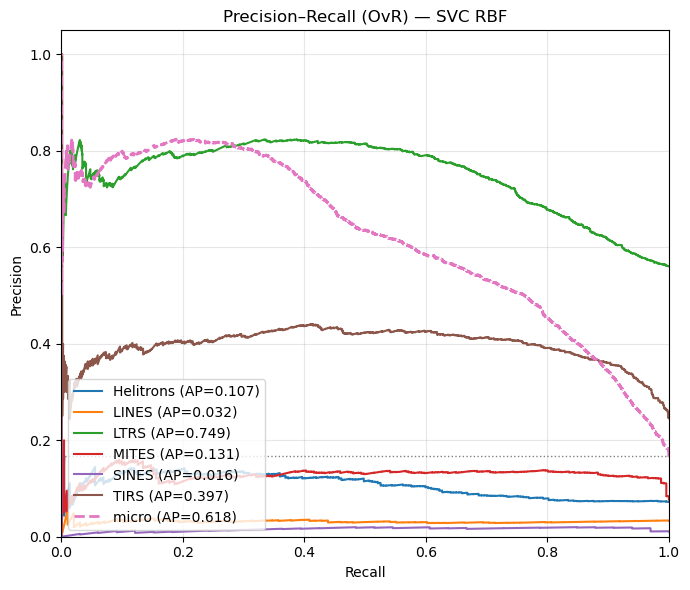

In [11]:
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, precision_recall_curve, average_precision_score
)
from sklearn.svm import SVC

# 1) Ler dados
df = pd.read_csv("df_concat_kmers.csv")

# 2) Separar X, y e descartar colunas de id/texto
y = df["Classe"]
X = df.drop(columns=["Classe", "Sequencia", "id", "nameseq"], errors="ignore")

# 3) Pré-processamento: escala em numéricos + one-hot em categóricos
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# compat: sklearn >=1.2 usa sparse_output; versões anteriores usam sparse
try:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", encoder,   cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# 4) Split 70/30 estratificado
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# 5) Modelo: SVC RBF com balanceamento
svc = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    class_weight="balanced",   # peso inverso à frequência das classes
    probability=True,          # para obter predict_proba (útil p/ PR/AP)
    random_state=42
)

pipe = make_pipeline(pre, svc)

# 6) Treinar e prever
warnings.filterwarnings("ignore")
pipe.fit(Xtr, ytr)
yp = pipe.predict(Xte)

# 7) Métricas gerais
print("=== Métricas Hold-out (70/30) — SVC RBF ===")
print("Accuracy           :", accuracy_score(yte, yp))
print("Balanced Accuracy  :", balanced_accuracy_score(yte, yp))
print("F1-macro           :", f1_score(yte, yp, average='macro'))
print("\nRelatório por classe:\n")
print(classification_report(yte, yp, digits=3, zero_division=0))

# 8) Curvas Precision–Recall e Average Precision (AP)
proba   = pipe.predict_proba(Xte)               # (n_amostras, n_classes)
classes = pipe.named_steps["svc"].classes_      # ordem das classes

# Binariza y verdadeiro de acordo com a ordem 'classes'
Yte_bin = label_binarize(yte, classes=classes)  # shape: (n_amostras, n_classes)

# PR por classe
precision, recall, ap = {}, {}, {}
for i, cls in enumerate(classes):
    precision[cls], recall[cls], _ = precision(order='F')['copy'] if False else precision_recall_curve(
        Yte_bin[:, i], proba[:, i]
    )
    ap[cls] = average_precision_score(Yte_bin[:, i], proba[:, i])

# Micro-average (une todas as classes)
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Yte_bin.ravel(), proba.ravel()
)
ap["micro"] = average_precision_score(Yte_bin, proba, average="micro")

# Macro-average (média dos APs por classe)
ap["macro"] = average_precision_score(Yte_bin, proba, average="macro")

print("AP (área sob a PR):")
for cls in classes:
    print(f"  {cls}: {ap[cls]:.3f}")
print(f"AP micro-average: {ap['micro']:.3f}")
print(f"AP macro-average: {ap['macro']:.3f}")

# Linha de base (prevalência média da classe positiva no esquema OvR)
baseline = Yte_bin.mean()  # fração média de positivos (todas as classes)

# 9) Plot — PR por classe + micro-average
plt.figure(figsize=(7,6))
for cls in classes:
    plt.plot(recall[cls], precision[cls], lw=1.5, label=f"{cls} (AP={ap[cls]:.3f})")

# micro-average como linha tracejada
plt.plot(recall["micro"], precision["micro"], linestyle="--", lw=2.0,
         label=f"micro (AP={ap['micro']:.3f})")

# linha de base (prevalência de positivos)
plt.hlines(baseline, xmin=0, xmax=1, colors='gray', linestyles=':', lw=1)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (OvR) — SVC RBF")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


#### Random Forest

=== Métricas Hold-out (70/30) — RandomForest ===
Accuracy           : 0.5776293823038398
Balanced Accuracy  : 0.19351276742581092
F1-macro           : 0.17230008696744434

Relatório por classe:

              precision    recall  f1-score   support

   Helitrons      0.000     0.000     0.000       217
       LINES      0.000     0.000     0.000        98
        LTRS      0.596     0.927     0.726      1680
       MITES      0.000     0.000     0.000       231
       SINES      0.000     0.000     0.000        33
        TIRS      0.451     0.234     0.308       736

    accuracy                          0.578      2995
   macro avg      0.175     0.194     0.172      2995
weighted avg      0.445     0.578     0.483      2995

AP (área sob a PR):
  Helitrons: 0.146
  LINES: 0.043
  LTRS: 0.774
  MITES: 0.160
  SINES: 0.018
  TIRS: 0.406
AP micro-average: 0.632
AP macro-average: 0.258


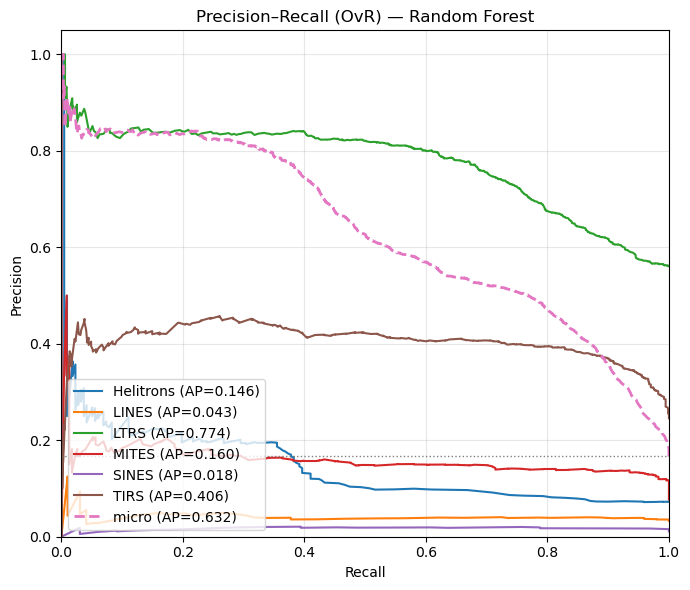

In [13]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, precision_recall_curve, average_precision_score
)
from sklearn.ensemble import RandomForestClassifier

# 1) Ler dados
df = pd.read_csv("df_concat_kmers.csv")

# 2) Separar X, y e descartar colunas não preditoras
y = df["Classe"]
X = df.drop(columns=["Classe", "Sequencia", "id"], errors="ignore")

# 3) Pré-processamento (árvores não precisam de escala, mas manter não atrapalha)
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# compatibilidade sklearn >=1.2 (sparse_output) e <1.2 (sparse)
try:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", encoder, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# 4) Split 70/30 estratificado
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# 5) Modelo: Random Forest (multiclasse naturalmente)
rf = RandomForestClassifier(
    n_estimators=600,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

pipe = make_pipeline(pre, rf)

# 6) Treinar e prever
warnings.filterwarnings("ignore")
pipe.fit(Xtr, ytr)
yp = pipe.predict(Xte)

# 7) Métricas gerais
print("=== Métricas Hold-out (70/30) — RandomForest ===")
print("Accuracy           :", accuracy_score(yte, yp))
print("Balanced Accuracy  :", balanced_accuracy_score(yte, yp))
print("F1-macro           :", f1_score(yte, yp, average="macro"))
print("\nRelatório por classe:\n")
print(classification_report(yte, yp, digits=3, zero_division=0))

# 8) Curvas Precision–Recall (OvR) e Average Precision (AP)
proba = pipe.predict_proba(Xte)  # (n_amostras, n_classes)
classes = pipe.named_steps["randomforestclassifier"].classes_

# binariza y conforme a ordem de 'classes'
Yte_bin = label_binarize(yte, classes=classes)  # shape: (n_amostras, n_classes)

precision, recall, ap = {}, {}, {}
for i, cls in enumerate(classes):
    p, r, _ = precision_recall_curve(Yte_bin[:, i], proba[:, i])
    precision[cls], recall[cls] = p, r
    ap[cls] = average_precision_score(Yte_bin[:, i], proba[:, i])

# micro-average (todas as classes achatadas)
p_micro, r_micro, _ = precision_recall_curve(Yte_bin.ravel(), proba.ravel())
precision["micro"], recall["micro"] = p_micro, r_micro
ap["micro"] = average_precision_score(Yte_bin, proba, average="micro")

# macro-average (média dos APs por classe)
ap["macro"] = average_precision_score(Yte_bin, proba, average="macro")

print("AP (área sob a PR):")
for cls in classes:
    print(f"  {cls}: {ap[cls]:.3f}")
print(f"AP micro-average: {ap['micro']:.3f}")
print(f"AP macro-average: {ap['macro']:.3f}")

# Linha de base: prevalência média da classe positiva no esquema OvR
baseline = Yte_bin.mean()

# 9) Plot — PR por classe + micro-average
plt.figure(figsize=(7,6))
for cls in classes:
    plt.plot(recall[cls], precision[cls], lw=1.5, label=f"{cls} (AP={ap[cls]:.3f})")

plt.plot(recall["micro"], precision["micro"], linestyle="--", lw=2.0,
         label=f"micro (AP={ap['micro']:.3f})")

# linha de base de precisão (prevalência)
plt.hlines(baseline, xmin=0, xmax=1, colors='gray', linestyles=':', lw=1)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (OvR) — Random Forest")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


### Fourier - Modelos

#### SVC - RBF

=== Métricas Hold-out (70/30) — SVC RBF ===
Accuracy           : 0.24874791318864775
Balanced Accuracy  : 0.3136978596105024
F1-macro           : 0.1888363791652463

Relatório por classe:

              precision    recall  f1-score   support

   Helitrons      0.207     0.313     0.250       217
       LINES      0.048     0.327     0.083        98
        LTRS      0.847     0.293     0.436      1680
       MITES      0.151     0.407     0.220       231
       SINES      0.023     0.485     0.045        33
        TIRS      0.408     0.057     0.100       736

    accuracy                          0.249      2995
   macro avg      0.281     0.314     0.189      2995
weighted avg      0.604     0.249     0.307      2995

AP (área sob a PR):
  Helitrons: 0.151
  LINES: 0.062
  LTRS: 0.788
  MITES: 0.174
  SINES: 0.020
  TIRS: 0.420
AP micro-average: 0.652
AP macro-average: 0.269


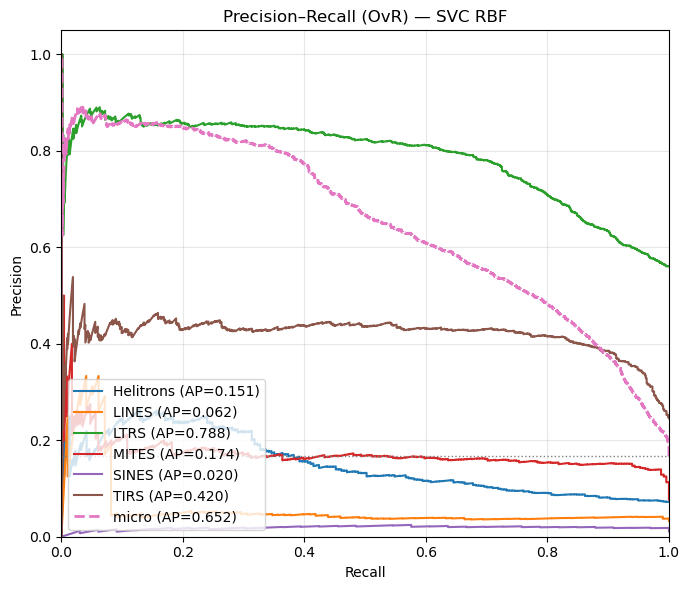

In [14]:
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, precision_recall_curve, average_precision_score
)
from sklearn.svm import SVC

# 1) Ler dados
df = pd.read_csv("df_concat_fourier.csv")

# 2) Separar X, y e descartar colunas de id/texto
y = df["Classe"]
X = df.drop(columns=["Classe", "Sequencia", "id", "nameseq"], errors="ignore")

# 3) Pré-processamento: escala em numéricos + one-hot em categóricos
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# compat: sklearn >=1.2 usa sparse_output; versões anteriores usam sparse
try:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", encoder, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# 4) Split 70/30 estratificado
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# 5) Modelo: SVC RBF com balanceamento
svc = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    class_weight="balanced",
    probability=True,          # necessário para obter proba para PR/AP
    random_state=42
)

pipe = make_pipeline(pre, svc)

# 6) Treinar e prever
warnings.filterwarnings("ignore")
pipe.fit(Xtr, ytr)
yp = pipe.predict(Xte)

# 7) Métricas gerais
print("=== Métricas Hold-out (70/30) — SVC RBF ===")
print("Accuracy           :", accuracy_score(yte, yp))
print("Balanced Accuracy  :", balanced_accuracy_score(yte, yp))
print("F1-macro           :", f1_score(yte, yp, average="macro"))
print("\nRelatório por classe:\n")
print(classification_report(yte, yp, digits=3, zero_division=0))

# 8) Curvas Precision–Recall (OvR) e Average Precision (AP)
proba   = pipe.predict_proba(Xte)               # (n_amostras, n_classes)
classes = pipe.named_steps["svc"].classes_      # ordem das classes

# binariza y de acordo com a ordem 'classes'
Yte_bin = label_binarize(yte, classes=classes)  # shape: (n_amostras, n_classes)

precision, recall, ap = {}, {}, {}
for i, cls in enumerate(classes):
    p, r, _ = precision_recall_curve(Yte_bin[:, i], proba[:, i])
    precision[cls], recall[cls] = p, r
    ap[cls] = average_precision_score(Yte_bin[:, i], proba[:, i])

# micro-average (achatando todas as classes)
p_micro, r_micro, _ = precision_recall_curve(Yte_bin.ravel(), proba.ravel())
precision["micro"], recall["micro"] = p_micro, r_micro
ap["micro"] = average_precision_score(Yte_bin, proba, average="micro")

# macro-average (média simples dos APs por classe)
ap["macro"] = average_precision_score(Yte_bin, proba, average="macro")

print("AP (área sob a PR):")
for cls in classes:
    print(f"  {cls}: {ap[cls]:.3f}")
print(f"AP micro-average: {ap['micro']:.3f}")
print(f"AP macro-average: {ap['macro']:.3f}")

# Linha de base: prevalência média da classe positiva no esquema OvR
baseline = Yte_bin.mean()

# 9) Plot — PR por classe + micro-average
plt.figure(figsize=(7,6))
for cls in classes:
    plt.plot(recall[cls], precision[cls], lw=1.5, label=f"{cls} (AP={ap[cls]:.3f})")

plt.plot(recall["micro"], precision["micro"], linestyle="--", lw=2.0,
         label=f"micro (AP={ap['micro']:.3f})")

# linha de base de precisão (prevalência)
plt.hlines(baseline, xmin=0, xmax=1, colors='gray', linestyles=':', lw=1)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (OvR) — SVC RBF")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


#### Random Forest


=== Métricas Hold-out (70/30) — RandomForest ===
Accuracy           : 0.603338898163606
Balanced Accuracy  : 0.24115771393558913
F1-macro           : 0.22473150819154297

Relatório por classe:

              precision    recall  f1-score   support

   Helitrons      0.417     0.023     0.044       217
       LINES      0.000     0.000     0.000        98
        LTRS      0.693     0.817     0.750      1680
       MITES      0.242     0.035     0.061       231
       SINES      0.000     0.000     0.000        33
        TIRS      0.434     0.572     0.494       736

    accuracy                          0.603      2995
   macro avg      0.298     0.241     0.225      2995
weighted avg      0.545     0.603     0.550      2995

AP (área sob a PR):
  Helitrons: 0.145
  LINES: 0.045
  LTRS: 0.784
  MITES: 0.182
  SINES: 0.017
  TIRS: 0.404
AP micro-average: 0.640
AP macro-average: 0.263


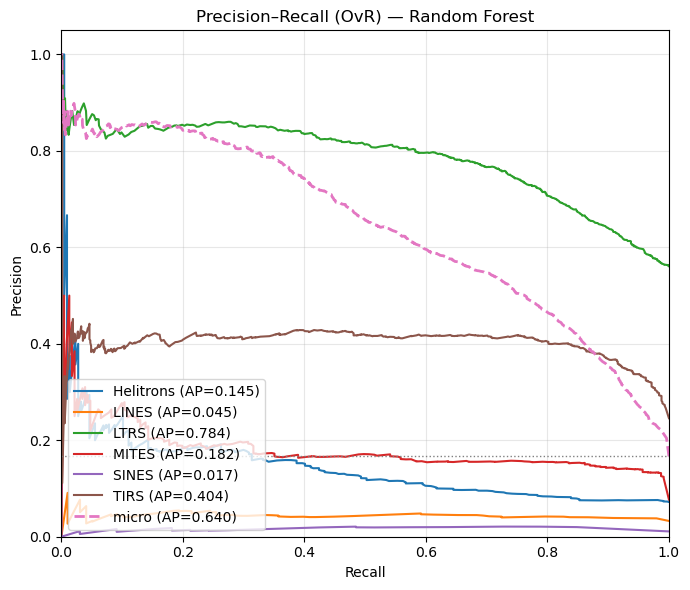

In [15]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    classification_report, precision_recall_curve, average_precision_score
)
from sklearn.ensemble import RandomForestClassifier

# 1) Ler dados
df = pd.read_csv("df_concat_fourier.csv")

# 2) Separar X, y e descartar colunas não preditoras
y = df["Classe"]
X = df.drop(columns=["Classe", "Sequencia", "id"], errors="ignore")

# 3) Pré-processamento (árvores não exigem escala, mas não atrapalha)
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# compatibilidade sklearn >=1.2 (sparse_output) e <1.2 (sparse)
try:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", encoder, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# 4) Split 70/30 estratificado
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# 5) Modelo: Random Forest
rf = RandomForestClassifier(
    n_estimators=600,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

pipe = make_pipeline(pre, rf)

# 6) Treinar e prever
warnings.filterwarnings("ignore")
pipe.fit(Xtr, ytr)
yp = pipe.predict(Xte)

# 7) Métricas gerais
print("=== Métricas Hold-out (70/30) — RandomForest ===")
print("Accuracy           :", accuracy_score(yte, yp))
print("Balanced Accuracy  :", balanced_accuracy_score(yte, yp))
print("F1-macro           :", f1_score(yte, yp, average="macro"))
print("\nRelatório por classe:\n")
print(classification_report(yte, yp, digits=3, zero_division=0))

# 8) Curvas Precision–Recall (OvR) e Average Precision (AP)
proba = pipe.predict_proba(Xte)  # matriz (n_amostras, n_classes)
classes = pipe.named_steps["randomforestclassifier"].classes_

# binariza y conforme a ordem de 'classes'
Yte_bin = label_binarize(yte, classes=classes)  # shape: (n_amostras, n_classes)

precision, recall, ap = {}, {}, {}
for i, cls in enumerate(classes):
    p, r, _ = precision_recall_curve(Yte_bin[:, i], proba[:, i])
    precision[cls], recall[cls] = p, r
    ap[cls] = average_precision_score(Yte_bin[:, i], proba[:, i])

# micro-average (achatando todas as classes)
p_micro, r_micro, _ = precision_recall_curve(Yte_bin.ravel(), proba.ravel())
precision["micro"], recall["micro"] = p_micro, r_micro
ap["micro"] = average_precision_score(Yte_bin, proba, average="micro")

# macro-average (média dos APs por classe)
ap["macro"] = average_precision_score(Yte_bin, proba, average="macro")

print("AP (área sob a PR):")
for cls in classes:
    print(f"  {cls}: {ap[cls]:.3f}")
print(f"AP micro-average: {ap['micro']:.3f}")
print(f"AP macro-average: {ap['macro']:.3f}")

# Linha de base: prevalência média da classe positiva no esquema OvR
baseline = Yte_bin.mean()

# 9) Plot — PR por classe + micro-average
plt.figure(figsize=(7,6))
for cls in classes:
    plt.plot(recall[cls], precision[cls], lw=1.5, label=f"{cls} (AP={ap[cls]:.3f})")

plt.plot(recall["micro"], precision["micro"], linestyle="--", lw=2.0,
         label=f"micro (AP={ap['micro']:.3f})")

# linha de base de precisão (prevalência)
plt.hlines(baseline, xmin=0, xmax=1, colors='gray', linestyles=':', lw=1)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall (OvR) — Random Forest")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()
